In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import DistanceMetric
from math import radians

In [ ]:
data = pd.read_csv('/content/uber.csv')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Unnamed: 0         200000 non-null  int64  
 1   key                200000 non-null  object 
 2   fare_amount        200000 non-null  float64
 3   pickup_datetime    200000 non-null  object 
 4   pickup_longitude   200000 non-null  float64
 5   pickup_latitude    200000 non-null  float64
 6   dropoff_longitude  199999 non-null  float64
 7   dropoff_latitude   199999 non-null  float64
 8   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 13.7+ MB


In [ ]:
data.head()

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


In [ ]:
data.nunique()

Unnamed: 0           200000
key                  200000
fare_amount            1244
pickup_datetime      196629
pickup_longitude      71066
pickup_latitude       83835
dropoff_longitude     76894
dropoff_latitude      90585
passenger_count           8
dtype: int64

In [ ]:
#  Dropping the columns 'Unnamed: 0' and 'key' as well as NA rows

data = data.drop(['Unnamed: 0','key'],axis=1)
data.dropna(axis=0,inplace=True)

In [ ]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
fare_amount,199999.0,11.359892,9.901760,-52.000000,6.000000,8.500000,12.500000,499.000000
pickup_longitude,199999.0,-72.527631,11.437815,-1340.648410,-73.992065,-73.981823,-73.967154,57.418457
pickup_latitude,199999.0,39.935881,7.720558,-74.015515,40.734796,40.752592,40.767158,1644.421482
dropoff_longitude,199999.0,-72.525292,13.117408,-3356.666300,-73.991407,-73.980093,-73.963658,1153.572603
dropoff_latitude,199999.0,39.923890,6.794829,-881.985513,40.733823,40.753042,40.768001,872.697628
passenger_count,199999.0,1.684543,1.385995,0.000000,1.000000,1.000000,2.000000,208.000000


In [ ]:
data.corr()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
fare_amount,1.000000,0.010458,-0.008482,0.008986,-0.011014,0.010158
pickup_longitude,0.010458,1.000000,-0.816461,0.833026,-0.846324,-0.000415
pickup_latitude,-0.008482,-0.816461,1.000000,-0.774787,0.702367,-0.001559
dropoff_longitude,0.008986,0.833026,-0.774787,1.000000,-0.917010,0.000033
dropoff_latitude,-0.011014,-0.846324,0.702367,-0.917010,1.000000,-0.000659
passenger_count,0.010158,-0.000415,-0.001559,0.000033,-0.000659,1.000000


Inference :

Possibility of some outliers in fare amount and passanger

Outliers:
Fare Amount is between -52 to 499. The negative amount seems unrealistic.

Base fare to be set at $2.5

Passanger count max is 208, which is also not possible.
Max to be set at 5


<Axes: >

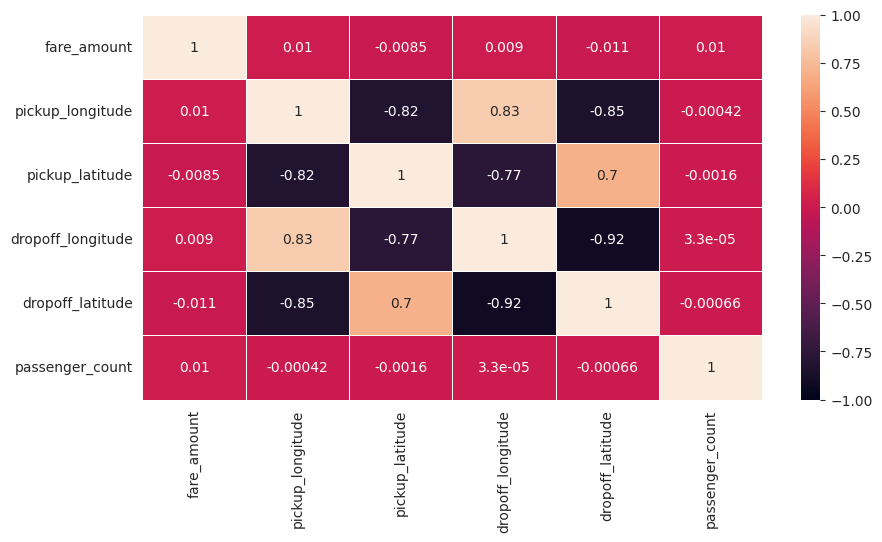

In [ ]:
plt.figure(figsize=(10,5))
sns.heatmap(data.corr(), annot=True, linewidths=.5, vmin = -1, vmax = 1, fmt = '.2g')

High correlation can be observed between the geo-spatial data points.

We use this points to calculate the Distance travelled_in_km

Haversine Distance haversine formula to calculate the distance traveled in km (using pickup and drop off latitude and longitude).

d = 2r * arcsin(√(sin²(Δlat/2) + cos(lat1) * cos(lat2) * sin²(Δlon/2)))



In [ ]:
from math import *
def distance(longitude1, latitude1, longitude2, latitude2):
    travel_dist = []

    for pos in range(len(longitude1)):
        long1,lati1,long2,lati2 = map(radians,[longitude1[pos],latitude1[pos],longitude2[pos],latitude2[pos]])
        dist_long = long2 - long1
        dist_lati = lati2 - lati1
        a = sin(dist_lati/2)**2 + cos(lati1) * cos(lati2) * sin(dist_long/2)**2
        c = 2 * asin(sqrt(a))*6371
        travel_dist.append(c)

    return travel_dist

In [ ]:
data['distance_travelled'] = distance(data['pickup_longitude'].to_numpy(),
                                                data['pickup_latitude'].to_numpy(),
                                                data['dropoff_longitude'].to_numpy(),
                                                data['dropoff_latitude'].to_numpy()
                                              )

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199999 entries, 0 to 199999
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   fare_amount         199999 non-null  float64
 1   pickup_datetime     199999 non-null  object 
 2   pickup_longitude    199999 non-null  float64
 3   pickup_latitude     199999 non-null  float64
 4   dropoff_longitude   199999 non-null  float64
 5   dropoff_latitude    199999 non-null  float64
 6   passenger_count     199999 non-null  int64  
 7   distance_travelled  199999 non-null  float64
dtypes: float64(6), int64(1), object(1)
memory usage: 13.7+ MB


In [ ]:
data['pickup_datetime']  = pd.to_datetime(data['pickup_datetime'])

In [ ]:
data.dtypes

fare_amount                       float64
pickup_datetime       datetime64[ns, UTC]
pickup_longitude                  float64
pickup_latitude                   float64
dropoff_longitude                 float64
dropoff_latitude                  float64
passenger_count                     int64
distance_travelled                float64
dtype: object

In [ ]:
from datetime import datetime

data['date'] = pd.to_datetime(data['pickup_datetime']).dt.date
data['month'] = pd.to_datetime(data['pickup_datetime']).dt.month
data['year'] = pd.to_datetime(data['pickup_datetime']).dt.year
data['day_of_the_week'] = pd.to_datetime(data['pickup_datetime']).dt.weekday
data['day_name'] = pd.to_datetime(data['pickup_datetime']).dt.day_name()
data['pickup_time'] = pd.to_datetime(data['pickup_datetime']).dt.time
data['pickup_hour'] = pd.to_datetime(data['pickup_datetime']).dt.hour

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199999 entries, 0 to 199999
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype              
---  ------              --------------   -----              
 0   fare_amount         199999 non-null  float64            
 1   pickup_datetime     199999 non-null  datetime64[ns, UTC]
 2   pickup_longitude    199999 non-null  float64            
 3   pickup_latitude     199999 non-null  float64            
 4   dropoff_longitude   199999 non-null  float64            
 5   dropoff_latitude    199999 non-null  float64            
 6   passenger_count     199999 non-null  int64              
 7   distance_travelled  199999 non-null  float64            
 8   date                199999 non-null  object             
 9   month               199999 non-null  int64              
 10  year                199999 non-null  int64              
 11  day_of_the_week     199999 non-null  int64              
 12  day_name        

In [ ]:
data.drop(data[data['passenger_count'] > 5].index, axis=0, inplace = True)
data.drop(data[data['passenger_count'] == 0].index, axis=0, inplace = True)
data.drop(data[data['fare_amount'] < 2.5].index, axis=0, inplace = True)
data.drop(data[data['distance_travelled'] > 130].index, axis=0, inplace = True)
data.drop(data[data['distance_travelled'] == 0].index, axis=0, inplace = True)
data.dropna(axis=0,inplace=True)

In [ ]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
fare_amount,189061.0,11.336739,9.730745,2.500000,6.000000,8.500000,12.500000,499.000000
pickup_longitude,189061.0,-73.916225,2.560946,-75.419276,-73.992274,-73.982133,-73.968465,40.808425
pickup_latitude,189061.0,40.696089,2.634751,-74.015515,40.736440,40.753273,40.767532,401.066667
dropoff_longitude,189061.0,-73.915258,2.561027,-75.423067,-73.991594,-73.980564,-73.965513,40.831932
dropoff_latitude,189061.0,40.694481,2.501323,-74.015750,40.735345,40.753738,40.768327,45.031598
passenger_count,189061.0,1.595115,1.150926,1.000000,1.000000,1.000000,2.000000,5.000000
distance_travelled,189061.0,3.377859,3.984585,0.000084,1.279954,2.181325,3.938054,129.610094
month,189061.0,6.282337,3.439349,1.000000,3.000000,6.000000,9.000000,12.000000
year,189061.0,2011.719302,1.862527,2009.000000,2010.000000,2012.000000,2013.000000,2015.000000
day_of_the_week,189061.0,3.049095,1.946679,0.000000,1.000000,3.000000,5.000000,6.000000


In [ ]:
# Dropping the columns 'pickup datetime' and 'pickup hour' as we have extracted relvant pieces of information
# from these columns and do not need these columns for our analysis now. Also, 'date' and 'day_name', month and year
# as well as pickup and dropoff coordinates are not required as we have the required data extracted from them

data = data.drop(['pickup_datetime','pickup_time', 'date', 'pickup_longitude', 'pickup_latitude',
                  'dropoff_longitude', 'dropoff_latitude', 'day_name'],axis=1)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 189061 entries, 0 to 199999
Data columns (total 7 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   fare_amount         189061 non-null  float64
 1   passenger_count     189061 non-null  int64  
 2   distance_travelled  189061 non-null  float64
 3   month               189061 non-null  int64  
 4   year                189061 non-null  int64  
 5   day_of_the_week     189061 non-null  int64  
 6   pickup_hour         189061 non-null  int64  
dtypes: float64(2), int64(5)
memory usage: 11.5 MB


<Axes: xlabel='distance_travelled'>

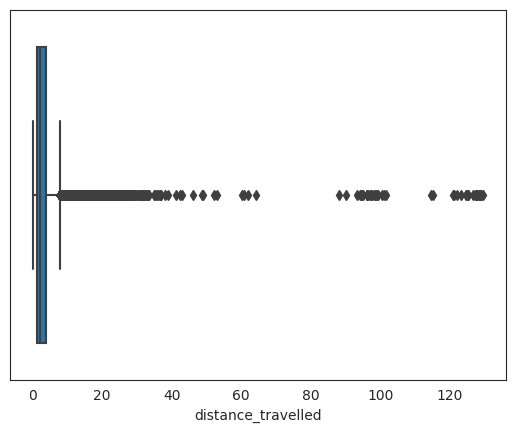

In [ ]:
sns.boxplot(x=data['distance_travelled'])

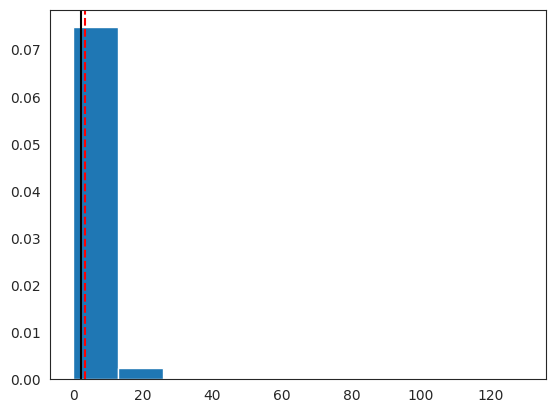

In [ ]:
import matplotlib.pyplot as plt
hist = plt.hist(x=data['distance_travelled'], density = True)
# Draw a vertical line in the histogram to visualize mean value of the numerical feature (NaNs will be ignored when calculating the mean)
plt.axvline(data['distance_travelled'].mean(), color = 'red', linestyle='--')
# Draw another vertical line in the histogram to visualize median value of the numerical feature (NaNs will be ignored when calculating the median)
plt.axvline(data['distance_travelled'].median(), color = 'black', linestyle='-')

Inference:

Positively Skewed

Outliers on the left end

Mean and Median are close

<Axes: >

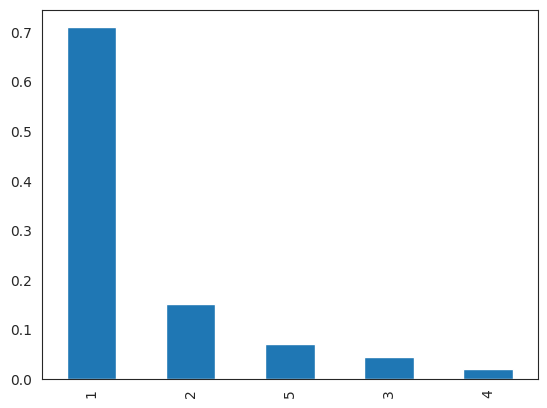

In [ ]:
data['passenger_count'].value_counts(normalize = True).plot.bar()

Inference:

Most of trips had only 1 passanger

<Axes: >

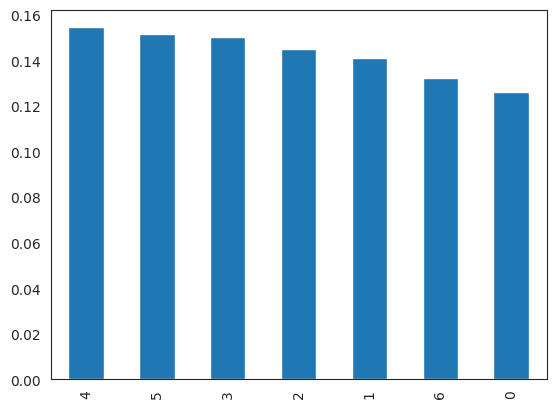

In [ ]:
data['day_of_the_week'].value_counts(normalize = True).plot.bar()

Inference :
Friday (weekend eve) and Saturday had the highest number of trips

<Axes: >

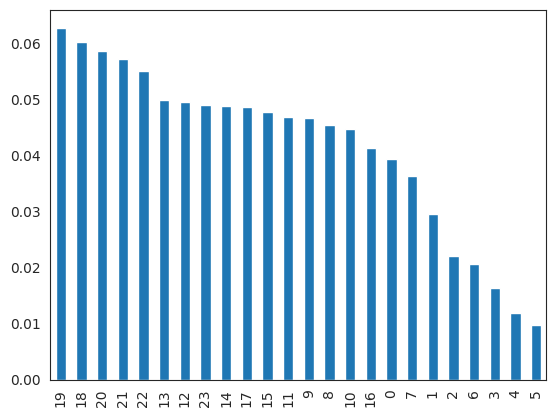

In [ ]:
data['pickup_hour'].value_counts(normalize = True).plot.bar()

Inference : The number of trips are low during 1am - 5am, and peak between 7pm - 9pm

<Axes: title={'center': 'Cab trips count during week days'}, xlabel='pickup_hour', ylabel='count'>

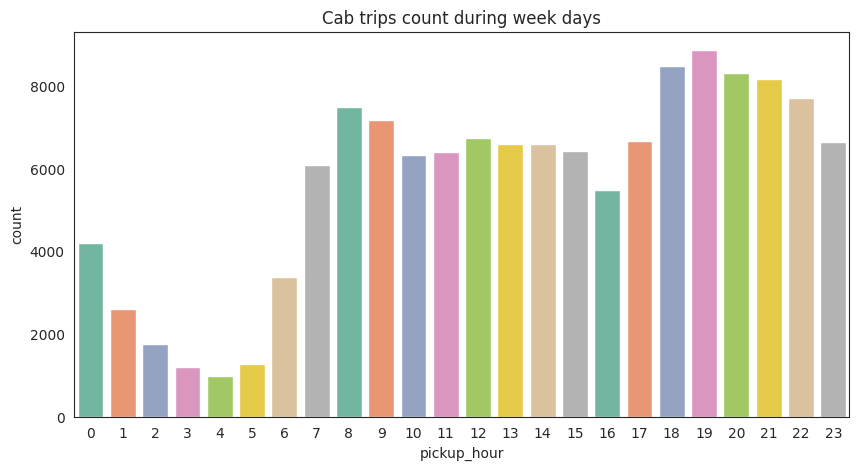

In [ ]:
plt.figure(figsize=(10,5))
plt.title('Cab trips count during week days')
sns.set_style("white")
#plot the countplot for weekdays
sns.countplot(x='pickup_hour', data=data.loc[(data.day_of_the_week >= 0) & (data.day_of_the_week <=4)], palette='Set2')

<Axes: title={'center': 'Cab trips count during weekends'}, xlabel='pickup_hour', ylabel='count'>

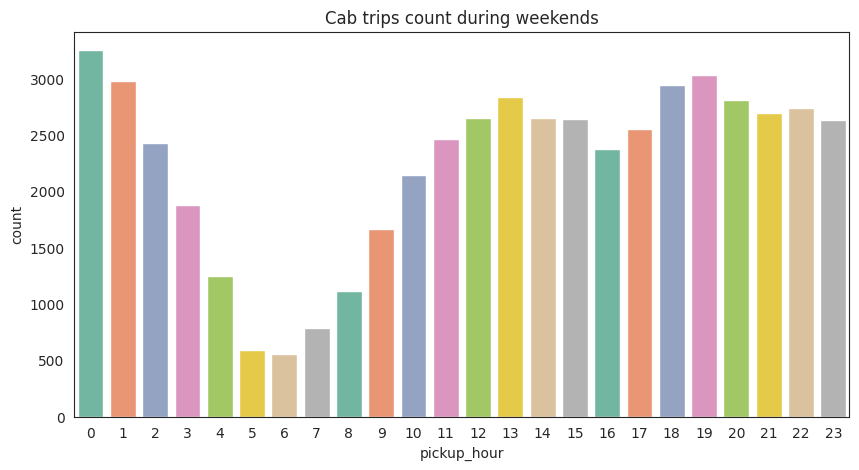

In [ ]:
plt.figure(figsize=(10,5))
plt.title('Cab trips count during weekends')
sns.set_style("white")
#plot the countplot for weekends
sns.countplot(x='pickup_hour', data=data.loc[(data.day_of_the_week >= 5) & (data.day_of_the_week <=6)], palette='Set2')

From the above plot, we can notice that the pattern for demand of Cab is different for weekdays and weekends.


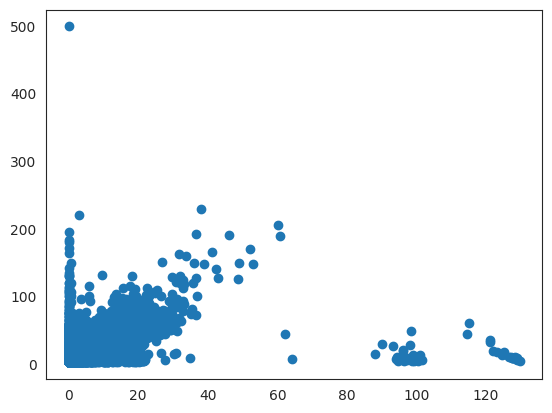

In [ ]:
plt.scatter(x = data.distance_travelled, y = data.fare_amount)
plt.show()

Inference : as distance increases, the fare amount also increases
but there are certain inconsistencies

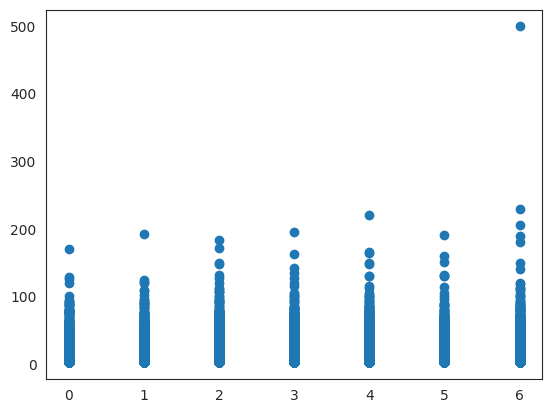

In [ ]:
#Scatter plot of day of the week vs fare amount
plt.scatter(x = data.day_of_the_week, y = data.fare_amount)
plt.show()

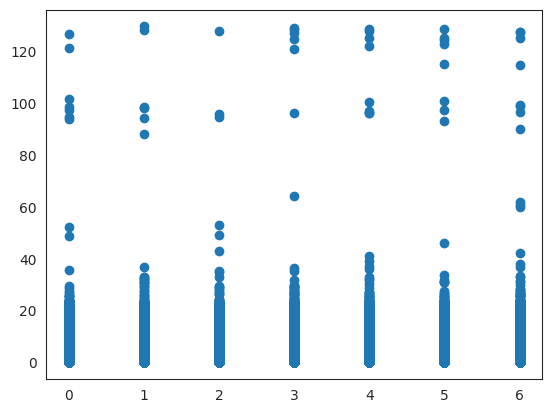

In [ ]:
#Scatter plot of day of the week vs distance to see if there is any relationship between them
plt.scatter(x = data.day_of_the_week, y = data.distance_travelled)
plt.show()

Inference : weekend fares are higher than weekday fares. This could be due to distance travelled or due to peak hours

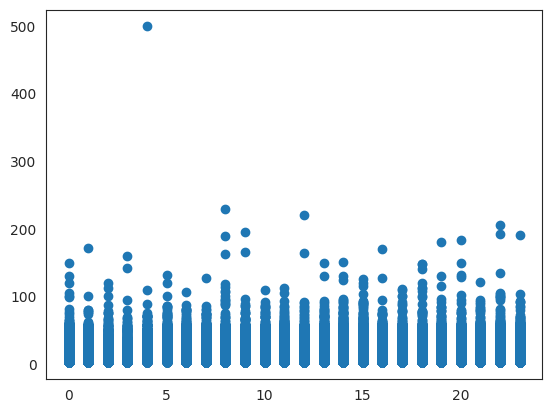

In [ ]:
#Scatter plot of pickup time vs fare amount
plt.scatter(x = data.pickup_hour, y = data.fare_amount)
plt.show()

Inference : some pickup times having a greater % of higher fares as compared to others - however, it is difficult to draw a concluding relationship

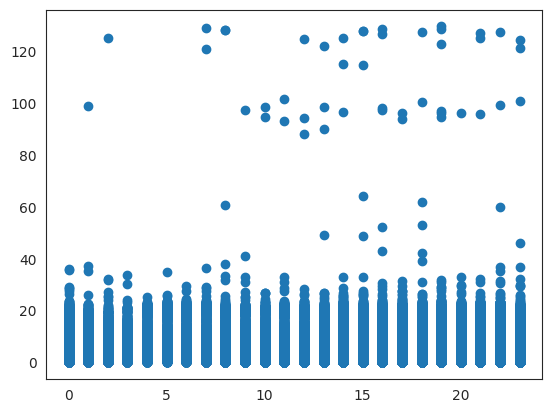

In [ ]:
plt.scatter(x = data.pickup_hour, y = data.distance_travelled)
plt.show()

Inference : Some pickup hours have a greater concentration of trips where a high distance was travelled as compared to others

In [ ]:
#Feature Scaling (Standardization)

from sklearn.preprocessing import StandardScaler

std = StandardScaler()

Standard scaler is less sensitive to outliers as compared to min max scaler. Our dataset has many outliers

In [ ]:
x = data.drop(['fare_amount'], axis = 1)
y = data['fare_amount'].values.reshape(-1, 1)

In [ ]:
y_std = std.fit_transform(y)

x_std = std.fit_transform(x)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_std, y_std, test_size = 0.3, random_state = 0)

In [ ]:
from sklearn.linear_model import LinearRegression

LR = LinearRegression()
LR.fit(x_train,y_train)

LR_pred = LR.predict(x_test)

print("Accuracy: {:.7f}".format(LR.score(x_test, y_test)))

Accuracy: 0.6376743


In [ ]:
from sklearn import metrics
from sklearn.metrics import r2_score

MAE_LR= metrics.mean_absolute_error(y_test, LR_pred)
MSE_LR= metrics.mean_squared_error(y_test, LR_pred)
RMSE_LR= np.sqrt(metrics.mean_squared_error(y_test, LR_pred))
r2_LR=r2_score(y_test, LR_pred)
Adj_r2_LR=1-(1-r2_score(y_test, LR_pred))*((len(x_test)-1)/(len(x_test)-len(x_test[0])-1))

In [ ]:
print('Mean absolute error of linear regression',MAE_LR)
print('Mean square  error of linear regression',MSE_LR)
print('Root Mean square error of linear regression',RMSE_LR)
print('r2 score of linear regression',r2_LR)
print('Adjusted r2 of linear regression',Adj_r2_LR)

Mean absolute error of linear regression 0.26009588958844887
Mean square  error of linear regression 0.3606759221003476
Root Mean square error of linear regression 0.6005630042721143
r2 score of linear regression 0.6376742734000511
Adjusted r2 of linear regression 0.6376359401661746


In [ ]:
from sklearn.tree import DecisionTreeRegressor

DT = DecisionTreeRegressor()
DT.fit(x_train, y_train)

DecisionTreeRegressor()

In [ ]:
DTpreds = DT.predict(x_test)
print("Training set score: {:.2f}".format(DT.score(x_train, y_train)))
print("Test set score: {:.7f}".format(DT.score(x_test, y_test)))

Training set score: 1.00
Test set score: 0.5657173


In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = {'max_depth': [2, 3, 4, 5, 6, 8, 10, 12],
              'min_samples_leaf': [2, 5, 10, 20]}

dt = DecisionTreeRegressor()
grid_dt = GridSearchCV(estimator=dt, param_grid=param_grid, cv=5)
grid_dt.fit(x_train, y_train)
print(grid_dt.best_params_)


dt = DecisionTreeRegressor(**grid_dt.best_params_)
dt.fit(x_train, y_train)
DTpreds = dt.predict(x_test)

{'max_depth': 8, 'min_samples_leaf': 10}


In [ ]:
MAE_DT= metrics.mean_absolute_error(y_test, DTpreds)
MSE_DT= metrics.mean_squared_error(y_test, DTpreds)
RMSE_DT= np.sqrt(metrics.mean_squared_error(y_test, DTpreds))
r2_DT=r2_score(y_test, DTpreds)
Adj_r2_DT=1-(1-r2_score(y_test, DTpreds))*((len(x_test)-1)/(len(x_test)-len(x_test[0])-1))

In [ ]:
print('Mean absolute error of decision tree', MAE_DT)
print('Mean square  error of decision tree', MSE_DT)
print('Root Mean square error of decision tree', RMSE_DT)
print('r2 score of decision tree', r2_DT)
print('Adjusted r2 of decision tree', Adj_r2_DT)

Mean absolute error of decision tree 0.21856659922020077
Mean square  error of decision tree 0.2070851905270563
Root Mean square error of decision tree 0.4550661386293824
r2 score of decision tree 0.7919675599944014
Adjusted r2 of decision tree 0.7919455506376509


In [ ]:
from sklearn.ensemble import RandomForestRegressor

RF = RandomForestRegressor()
RF.fit(x_train, y_train)

RFpreds = RF.predict(x_test)

print("Accuracy: {:.7f}".format(RF.score(x_test, y_test)))

<ipython-input-227-1b84e9f5d4fd>:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RF.fit(x_train, y_train)


Accuracy: 0.7843596


In [ ]:
MAE_RF= metrics.mean_absolute_error(y_test, RFpreds)
MSE_RF= metrics.mean_squared_error(y_test, RFpreds)
RMSE_RF= np.sqrt(metrics.mean_squared_error(y_test, RFpreds))
r2_RF=r2_score(y_test, RFpreds)
Adj_r2_RF=1-(1-r2_score(y_test, RFpreds))*((len(x_test)-1)/(len(x_test)-len(x_test[0])-1))

In [ ]:
print('Mean absolute error of random forest',MAE_RF)
print('Mean square  error of random forest',MSE_RF)
print('Root Mean square error of random forest',RMSE_RF)
print('r2 score of random forest',r2_RF)
print('Adjusted r2 of random forest',Adj_r2_RF)

Mean absolute error of random forest 0.22521716258609822
Mean square  error of random forest 0.21465849392007916
Root Mean square error of random forest 0.4633125229476095
r2 score of random forest 0.7843596147823686
Adjusted r2 of random forest 0.7843368005224006


In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
gbr = GradientBoostingRegressor(random_state = 0)
gbr.fit(x_train, y_train)
predictions_gbr = gbr.predict(x_test)

/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
print("Accuracy: {:.7f}".format(gbr.score(x_test, y_test)))

Accuracy: 0.7914934


In [ ]:
MAE_GBR= metrics.mean_absolute_error(y_test, predictions_gbr)
MSE_GBR= metrics.mean_squared_error(y_test, predictions_gbr)
RMSE_GBR= np.sqrt(metrics.mean_squared_error(y_test, predictions_gbr))
r2_GBR=r2_score(y_test, predictions_gbr)
Adj_r2_GBR=1-(1-r2_score(y_test, predictions_gbr))*((len(x_test)-1)/(len(x_test)-len(x_test[0])-1))

In [ ]:
print('Mean absolute error of gradient boosting regressor', MAE_GBR)
print('Mean square  error of gradient boosting regressor', MSE_GBR)
print('Root Mean square error of gradient boosting regressor', RMSE_GBR)
print('r2 score of gradient boosting regressor', r2_GBR)
print('Adjusted r2 of gradient boosting regressor', Adj_r2_GBR)

Mean absolute error of gradient boosting regressor 0.21214438568373514
Mean square  error of gradient boosting regressor 0.20755714467134648
Root Mean square error of gradient boosting regressor 0.45558439906492243
r2 score of gradient boosting regressor 0.7914934470365527
Adjusted r2 of gradient boosting regressor 0.7914713875197347


In [ ]:
from xgboost import XGBRegressor

In [ ]:
xgb = XGBRegressor(random_state = 0, scale_pos_weight = 1)
xgb.fit(x_train, y_train)
predictions_xgb = xgb.predict(x_test)

In [ ]:
print("Accuracy: {:.7f}".format(xgb.score(x_test, y_test)))

Accuracy: 0.7923300


In [ ]:
MAE_XGB= metrics.mean_absolute_error(y_test, predictions_xgb)
MSE_XGB= metrics.mean_squared_error(y_test, predictions_xgb)
RMSE_XGB= np.sqrt(metrics.mean_squared_error(y_test, predictions_xgb))
r2_XGB=r2_score(y_test, predictions_xgb)
Adj_r2_XGB=1-(1-r2_score(y_test, predictions_xgb))*((len(x_test)-1)/(len(x_test)-len(x_test[0])-1))

In [ ]:
print('Mean absolute error of XGB regressor',MAE_XGB)
print('Mean square  error of XGB regressor',MSE_XGB)
print('Root Mean square error of XGB regressor',RMSE_XGB)
print('r2 score of XGB regressor',r2_XGB)
print('Adjusted r2 of XGB regressor',Adj_r2_XGB)

Mean absolute error of XGB regressor 0.21027873805345706
Mean square  error of XGB regressor 0.20672442369923436
Root Mean square error of XGB regressor 0.45466957639502814
r2 score of XGB regressor 0.792329977042544
Adjusted r2 of XGB regressor 0.792308006028689


In [ ]:
cols = ['Model', 'MSE', 'RMSE', 'R2_score','MAE','ADJ_r']

# create an empty dataframe of the columns
result_table = pd.DataFrame(columns = cols)

In [ ]:
full_metrics = pd.Series({'Model': "Linear Regression", 'MSE': MSE_LR, 'RMSE' : RMSE_LR, 'R2_score' : r2_LR,'MAE':MAE_LR,'ADJ_r':Adj_r2_LR})

In [ ]:
result_table = result_table.append(full_metrics, ignore_index = True)

<ipython-input-242-d662c82ea80e>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_table = result_table.append(full_metrics, ignore_index = True)


In [ ]:
full_metrics = pd.Series({'Model': "Decision Tree", 'MSE': MSE_DT, 'RMSE' : RMSE_DT, 'R2_score' : r2_DT,'MAE':MAE_DT,'ADJ_r':Adj_r2_DT})

In [ ]:
result_table = result_table.append(full_metrics, ignore_index = True)

<ipython-input-244-d662c82ea80e>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_table = result_table.append(full_metrics, ignore_index = True)


In [ ]:
full_metrics = pd.Series({'Model': "Random Forest", 'MSE': MSE_RF, 'RMSE' : RMSE_RF, 'R2_score' : r2_RF,'MAE':MAE_RF,'ADJ_r':Adj_r2_RF})

In [ ]:
result_table = result_table.append(full_metrics, ignore_index = True)

<ipython-input-246-d662c82ea80e>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_table = result_table.append(full_metrics, ignore_index = True)


In [ ]:
full_metrics = pd.Series({'Model': "Gradient Boosting", 'MSE': MSE_GBR, 'RMSE' : RMSE_GBR, 'R2_score' : r2_GBR,'MAE':MAE_GBR,'ADJ_r':Adj_r2_GBR})

In [ ]:
result_table = result_table.append(full_metrics, ignore_index = True)

<ipython-input-248-d662c82ea80e>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_table = result_table.append(full_metrics, ignore_index = True)


In [ ]:
full_metrics = pd.Series({'Model': "XGBoost", 'MSE': MSE_XGB, 'RMSE' : RMSE_XGB, 'R2_score' : r2_XGB,'MAE':MAE_XGB,'ADJ_r':Adj_r2_XGB})

In [ ]:
result_table = result_table.append(full_metrics, ignore_index = True)

<ipython-input-250-d662c82ea80e>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_table = result_table.append(full_metrics, ignore_index = True)


In [ ]:
result_table

,Model,MSE,RMSE,R2_score,MAE,ADJ_r
0,Linear Regression,0.360676,0.600563,0.637674,0.260096,0.637636
1,Decision Tree,0.207085,0.455066,0.791968,0.218567,0.791946
2,Random Forest,0.214658,0.463313,0.784360,0.225217,0.784337
3,Gradient Boosting,0.207557,0.455584,0.791493,0.212144,0.791471
4,XGBoost,0.206724,0.454670,0.792330,0.210279,0.792308
